In [4]:
%reset -f

In [5]:
import requests
import json
import time

import pandas as pd
import numpy as np
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from pprint import pprint

In [2]:
# fix package version
!pip freeze > requirements.txt
# fix RANDOM_SEED

In [6]:
pd.set_option('display.max_rows', 50) # show more rows
pd.set_option('display.max_columns', 50) # show more columns
RANDOM_SEED = 42 # fix RANDOM_SEED

In [77]:
# load data
submit = pd.read_csv('data/submission_kaggle.csv')
test = pd.read_csv('data/test_kaggle.csv') # test data from kaggle
test.sample(1)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
4382,хэтчбек 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/a2/1100577...,чёрный,NaN,"Машина полностью обслужена, два комплекта ново...",1.2 LTR,61 N12,"{""tinted-glass"":true,""esp"":true,""ptf"":true,""st...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,179000,2000,"{""code"":""A2"",""name"":""A2"",""ru_name"":""А2"",""morph...",A2,1.2d AMT (61 л.с.),5,1603129457,RUB,2001,1100577972,"{""id"":""4720889"",""displacement"":1191,""engine_ty...",HATCHBACK_5_DOORS ROBOT 1.2,роботизированная,EUROPEAN,3 или более,7 лет и 3 месяца,Дубликат,передний,Левый,Не требует ремонта,Растаможен


## 0. Parsing

In [987]:
# save unque brands
brands = df_test.brand.unique()
brands

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [988]:
url = 'https://auto.ru/-/ajax/desktop/listing/'

param =  { # request paramters
    "catalog_filter": {"mark": "" },
	"category": "cars",
	"geo_id": 213,	# moscow region
	"geo_radius": 200,
	"page": '',
	"section": "used"
}

headers =  """
x-csrf-token: 84cdcc823a18ee2d1227f4c03d56e2ab5343d1a695027659
x-requested-with: fetch
content-type: application/json
Cookie: _csrf_token=84cdcc823a18ee2d1227f4c03d56e2ab5343d1a695027659; autoru_sid=a%3Ag6042469b2c9hrb08e1n1muei0n7e7gn.a0d602345514707622b6b24f21d5d4aa%7C1614956187510.604800.TPJZh4BUmN2Wt0FC_jmZrQ.NHzt-Jka93A1pmYOHgGzxnz4Brc2lQ0g7MdRW-DmzpY; autoruuid=g6042469b2c9hrb08e1n1muei0n7e7gn.a0d602345514707622b6b24f21d5d4aa; autoru_gdpr=1; suid=1d270ae91acc0fa82a86a19ea598ba32.5825ab4cd7b1312d26da39f617f8c149; from_lifetime=1615122225520; from=direct; yuidlt=1; yandexuid=5621063921614956192; crookie=Kuztm6dub/2iVJP2c+bLZ7mVDOwQLsORYc5dG81VEpwhIfPvhNzyLP/jxLClA7DoKXL+/6w7iT7XhGWDrxmU3u2sd74=; cmtchd=MTYxNDk1NjE5NzI1MA==; bltsr=1; autoru-visits-count=3; X-Vertis-DC=sas; autoru-visits-session-unexpired=1; spravka=dD0xNTgzNTg2MjI5O2k9ODQuNDIuMTg3LjEzMDt1PTE1ODM1ODYyMjk2NTEwNzY1MTU7aD1kOTBkOGQ0ZDJhZGRhZWNlYjY3MmI1MDQwNjcyNTYzZg==
""".strip().split('\n')

#proxies = {
#    "https": '88.205.225.203:3128',
#}

# convert headers to dictionary
headers_dict = dict(list(map(lambda h: h.split(': '), headers)))

In [262]:
offers = [] # list for collected data

# get all offers (long process)
for n in range(1,100):
    for brand in brands:
        param['page'] = n
        param["catalog_filter"]["mark"]=brand
        response = requests.post(url, json=param, headers=headers_dict)
        time.sleep(1)
        data = response.json() # get json    
        offers.extend(data['offers']) # add to list 'offers' every element from list

print("offers: ", len(offers))

offers:  26491


In [263]:
# save data to json file
with open('data/data.json', 'w') as f:
    json.dump(offers, f)

## 1. Preprocessing

### 1.1. prepare test data

In [280]:
# look at nan values in test data
nan = round(test.isna().sum()/test.shape[0]*100,1)
print("% of nan values:\n", nan[nan.values > 50] )
test.head(1)

% of nan values:
 complectation_dict    81.5
Владение              65.4
dtype: float64


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [281]:
# remove columns drom test data
drop_cols = ['car_url','complectation_dict','description','image','model_info','parsing_unixtime','priceCurrency','productionDate','vehicleConfiguration','super_gen','Владельцы','Владение','Состояние','Таможня']
test.drop(drop_cols, axis=1, inplace=True)

# rename columns
cols_dict = {
    'ПТС': 'pts',
    'Привод': 'gear',
    'Руль': 'wheel'
}
test.rename(columns=cols_dict, inplace=True)

print('test shape: ', test.shape)

test shape:  (34686, 18)


### 1.2. Create a train set

In [282]:
# load data from json file
with open('data/data.json', 'r', encoding='utf8') as f:
    offers = json.load(f)
len(offers)

26491

In [283]:
# coollect only cars with not empty price info
train_offers = []
for offer in offers:
    if offer['price_info']:
        train_offers.append(offer)
len(train_offers)

26394

In [284]:
def fill_keys(key1 ,key2, key3=None):
    """ fill keys if they are not existed """
    for train_offer in train_offers:        
        try: train_offer[key1][key2]
        except: train_offer[key1][key2] = {key3: np.nan}
        try: train_offer[key1][key2][key3]
        except: train_offer[key1][key2][key3] = np.nan
        
fill_keys('vehicle_info', 'configuration', 'human_name')
fill_keys('vehicle_info', 'configuration', 'doors_count')
fill_keys('vehicle_info', 'tech_param', 'power')
fill_keys('vehicle_info', 'tech_param', 'engine_type')
fill_keys('vehicle_info', 'tech_param', 'transmission')
fill_keys('vehicle_info', 'tech_param', 'gear_type')

In [285]:
train = pd.DataFrame() # create an empty train data

# create colums for train set
train.loc[:, 'bodyType'] = list(map(lambda x: x['vehicle_info']['configuration']['human_name'], train_offers))
train.loc[:, 'brand'] = list(map(lambda x: x['vehicle_info']['mark_info']['code'], train_offers))
train.loc[:, 'color'] = list(map(lambda x: x['color_hex'], train_offers))
train.loc[:, 'engineDisplacement'] = list(map(lambda x: str(x['lk_summary'][:3]), train_offers))
train.loc[:, 'enginePower'] = list(map(lambda x: x['vehicle_info']['tech_param']['power'], train_offers))
train.loc[:, 'equipment_dict'] = list(map(lambda x: str(x['vehicle_info']['equipment']), train_offers))
train.loc[:, 'fuelType'] = list(map(lambda x: x['vehicle_info']['tech_param']['engine_type'], train_offers))
train.loc[:, 'mileage'] = list(map(lambda x: x['state']['mileage'], train_offers))
train.loc[:, 'modelDate'] = list(map(lambda x: x['documents']['year'], train_offers))
train.loc[:, 'model_name'] = list(map(lambda x: x['vehicle_info']['model_info']['code'], train_offers))
train.loc[:, 'numberOfDoors'] = list(map(lambda x: x['vehicle_info']['configuration']['doors_count'], train_offers))
train.loc[:, 'sell_id'] = list(map(lambda x: x['id'], train_offers))
#train.loc[:, 'sell_id_long'] = list(map(lambda x: x['saleId'], train_offers))
train.loc[:, 'vehicleTransmission'] = list(map(lambda x: x['vehicle_info']['tech_param']['transmission'], train_offers))
train.loc[:, 'vendor'] = list(map(lambda x: x['vehicle_info']['vendor'], train_offers))
train.loc[:, 'pts'] = list(map(lambda x: x['documents']['pts'], train_offers))
train.loc[:, 'gear'] = list(map(lambda x: x['vehicle_info']['tech_param']['gear_type'], train_offers))
train.loc[:, 'wheel'] = list(map(lambda x: x['vehicle_info']['steering_wheel'], train_offers))
train.loc[:, 'lk_summary'] = list(map(lambda x: x['lk_summary'], train_offers))
train.loc[:, 'price'] = list(map(lambda x: x['price_info']['price'], train_offers))

print('duplicated rows: ', len(train) - len(train.drop_duplicates()) )
print('rows with nan: ', train.isnull().any().sum())
print("shape: ", train.shape)

duplicated rows:  290
rows with nan:  6
shape:  (26394, 19)


In [286]:
# drop duplicates and rows with nan
train.drop_duplicates(inplace=True)
train.dropna(axis=0, inplace=True)
print('train shape:\t\t', train.shape)
print('train unique sell_id:\t', train.sell_id.nunique())
print('train unique brands:', train.brand.nunique())
display(train.head(1))
display(test.head(1))

train shape:		 (26102, 19)
train unique sell_id:	 26102
train unique brands: 12


,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,pts,gear,wheel,lk_summary,price
0,Лифтбек,SKODA,C49648,1.4,150.0,{},GASOLINE,140000,2016,OCTAVIA,5.0,1102691650,ROBOT,EUROPEAN,ORIGINAL,FORWARD_CONTROL,LEFT,"1.4 AMT (150 л.с.), лифтбек, передний, бензин",795000


,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,name,numberOfDoors,sell_id,vehicleTransmission,vendor,pts,gear,wheel
0,лифтбек,SKODA,синий,1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,OCTAVIA,1.2 AMT (105 л.с.),5,1100575026,роботизированная,EUROPEAN,Оригинал,передний,Левый


### 1.3. Analyze columns

In [287]:
    # body_type
# convert to one register
train.loc[:,'bodyType'] = train.bodyType.str.lower()

In [288]:
    # color
# convert to one standard
color_dict = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
train.loc[:, 'color'] = train['color'].map(color_dict)

In [289]:
    # equipment_dict
# mak with 0 if have and 1 don't have equipment
train.loc[:, 'equipment_dict'] = train['equipment_dict'].notnull().map({False:0, True: 1})
test.loc[:, 'equipment_dict'] = test['equipment_dict'].notnull().map({False:0, True: 1})
print('train: ', train.equipment_dict.unique())
print('test: ',test.equipment_dict.unique())

train:  [1]
test:  [1 0]


In [290]:
# equipment_dict
# all offers in train data have equipment, so I drop this feature
train.drop('equipment_dict', axis=1, inplace=True)
test.drop('equipment_dict', axis=1, inplace=True)

In [292]:
    # engineDisplacement
# unique values
print(' train:\t', *train.engineDisplacement.unique())
print(' test:\t', *test.engineDisplacement.unique())

 train:	 1.4 1.2 1.6 2.0 1.8 3.0 2.3 2.8 Ele 2.9 2.5 3.5 1.5 2.4 1.3 4.8 4.4 5.6 3.7 5.0 2.1 5.5 4.7 6.2 4.0 4.6 5.7 4.5 2.7 3.6 3.2 3.8 4.2 1.7 6.0 3.4 0.6 2.6 1.0 3.3 1.9 0.7 3.1 4.1 2.2 6.6 5.8 4.3 5.9 5.4 5.2 6.3 1.1 4.9 3.9
 test:	 1.2 LTR 1.6 LTR 1.8 LTR 2.0 LTR 1.4 LTR 1.3 LTR 1.0 LTR 3.6 LTR 1.5 LTR 1.9 LTR 2.8 LTR 1.1 LTR 2.5 LTR 4.2 LTR 3.0 LTR 4.0 LTR 5.9 LTR 2.7 LTR 3.1 LTR 2.4 LTR 5.2 LTR 3.2 LTR 4.1 LTR 6.3 LTR 2.3 LTR 6.0 LTR 2.2 LTR 3.7 LTR 2.9 LTR 5.0 LTR 3.3 LTR 2.1 LTR 2.6 LTR  LTR 3.5 LTR 1.7 LTR 0.7 LTR 4.4 LTR 4.8 LTR 5.4 LTR 6.6 LTR 4.9 LTR 3.8 LTR 3.4 LTR 3.9 LTR 4.6 LTR 5.6 LTR 4.5 LTR 5.5 LTR 6.2 LTR 4.7 LTR 4.3 LTR 5.8 LTR 5.3 LTR 5.7 LTR


In [293]:
# engineDisplacement

# remove '  LTR' in test data
test.loc[:,'engineDisplacement'] = test.engineDisplacement.str[:3]

 # remove 'Ele' in train
train = train[train.engineDisplacement!='Ele']
 # 'replace  'LT' with most common value in order to sove test shape
test_ed_mode = test.engineDisplacement.mode().values[0]
test.loc[:, 'engineDisplacement'] = test.engineDisplacement.str.replace('LT', test_ed_mode)

# convert to float
train.loc[:,'engineDisplacement'] = train.engineDisplacement.astype(float)
test.loc[:, 'engineDisplacement'] = test.engineDisplacement.astype(float)

In [298]:
    # enginePower
# convert to int
train.loc[:,'enginePower'] = train.enginePower.astype('int')
test.loc[:,'enginePower'] = test.enginePower.str[:3].astype('int')

In [299]:
    # fuelType
# convert to one standard
fuel_dict = {
    'бензин': 'GASOLINE',
    'дизель': 'DIESEL',
    'гибрид': 'HYBRID',
    'электро': 'ELECTRO',
    'газ': 'LPG'
}
test.loc[:, 'fuelType'] = test['fuelType'].map(fuel_dict)

In [300]:
    # vehicleTransmission
# convert to one standard
vehicleTransmission_dict = {
    'автоматическая': 'AUTOMATIC',
    'роботизированная': 'ROBOT',
    'вариатор': 'VARIATOR',
    'механическая': 'MECHANICAL'
}
test.loc[:, 'vehicleTransmission'] = test['vehicleTransmission'].map(vehicleTransmission_dict)

In [301]:
    # pts
print('train:', *train.pts.unique(), sep='\t')
print('test: ', *test.pts.unique(), sep='\t')

train:	ORIGINAL	DUPLICATE
test: 	Оригинал	Дубликат	nan


In [302]:
# pts
# remove test data a row with NaN in colomns 'pts'

# convert to one standard
pts_dict = { 'Оригинал': 'ORIGINAL',
            'Дубликат': 'DUPLICATE'}
test.loc[:, 'pts'] = test['pts'].map(pts_dict)

# code with 1 and 0
train.loc[:, 'pts'] = train['pts'].map( { 'ORIGINAL':1, 'DUPLICATE':0 } )
test['pts'] = test['pts'].map( { 'ORIGINAL':1, 'DUPLICATE':0 }  )

In [303]:
    # gear
# convert to one standard
gear_dict = {
    'полный': 'ALL_WHEEL_DRIVE',
    'передний': 'FORWARD_CONTROL',
    'задний': 'REAR_DRIVE'
}
test.loc[:, 'gear'] = test['gear'].map(gear_dict)

In [304]:
    # whee
wheel_dict = {
    'Левый': 'LEFT',
    'Правый': 'RIGHT'    
}
test.loc[:, 'wheel'] = test['wheel'].map(wheel_dict)

In [305]:
    # gearbox

# create a new feature in train
train.loc[:, 'lk_summary'] = train.lk_summary.map(lambda x: x.split()[1])
# rename columns 'lk_summary" to 'gearbox'
train.rename(columns={"lk_summary": "gearbox"}, inplace=True)

# create a new feature in test
test.loc[:, 'gearbox'] = test['name'].map(lambda x: x.split(' (')[0].split()[-1])

# drop 'name' columns
test.drop('name', axis=1, inplace=True)

In [306]:
display(train.head(1))
display(test.head(1))
print('train shape:', train.shape, 'nan: ', train.isna().sum().sum())
print('test shape: ', test.shape, 'nan: ', test.isna().sum().sum())

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,pts,gear,wheel,gearbox,price
0,лифтбек,SKODA,бежевый,1.4,150,GASOLINE,140000,2016,OCTAVIA,5.0,1102691650,ROBOT,EUROPEAN,1,FORWARD_CONTROL,LEFT,AMT,795000


,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,sell_id,vehicleTransmission,vendor,pts,gear,wheel,gearbox
0,лифтбек,SKODA,синий,1.2,105,GASOLINE,74000,2013,OCTAVIA,5,1100575026,ROBOT,EUROPEAN,1.0,FORWARD_CONTROL,LEFT,AMT


train shape: (26034, 18) nan:  0
test shape:  (34686, 17) nan:  1


#### 1.4. save data

In [307]:
train.to_csv('data/train.csv', index = False)
test.to_csv('data/test.csv', index = False)

#### 1.5. load data

In [7]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['Train'] = 1 # mark train
test['Train'] = 0 # mark test

df = train.append(test, sort=False).reset_index(drop=True) # combine

## 2. EDA

In [9]:
bin_cols =  ['pts', 'wheel', ]
cat_cols = [
    'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors',
    'vehicleTransmission', 'vendor', 'gear', 'gearbox', 
]
num_cols = ['modelDate', 'engineDisplacement', 'mileage', 'enginePower']
target = 'price'

### 2.1. Numeric features

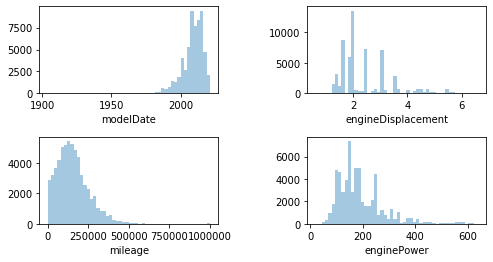

In [310]:
# numeric columns plots

fig, axes = plt.subplots(2, 2, figsize=(8,4))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
for col, i in zip(num_cols, range(len(num_cols))):
    sns.distplot(df[col], kde=False, ax=axes.flat[i])

In [10]:
# take a logarithm to improve the ditribution
for col in num_cols:
    df[col] = np.log(df[col] + 1)

In [312]:
# Pearson correlation for numeric columns
corr = df[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,modelDate,engineDisplacement,mileage,enginePower
modelDate,1.000,0.005,-0.519,0.276
engineDisplacement,0.005,1.000,-0.011,0.839
mileage,-0.519,-0.011,1.000,-0.187
enginePower,0.276,0.839,-0.187,1.000


High correlation have columns
'engineDisplacement' and 'enginePower'

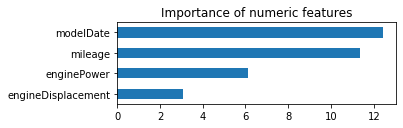

In [11]:
# importance of numeric features
df_train = df[df['Train']==1]

plt.figure(figsize=(5,1.5))
imp_num = Series(f_classif(df_train[num_cols], df_train[target])[0],
                 index = num_cols).sort_values()
imp_num.plot(kind = 'barh')
plt.title('Importance of numeric features')
plt.show()

### 2.2. Categorical features

In [12]:
# convert
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

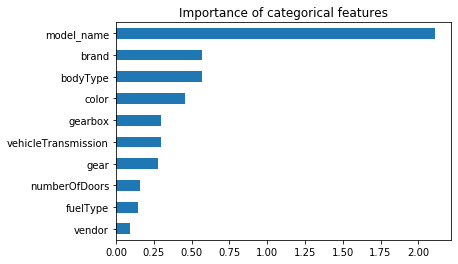

In [13]:
# importance of categorical and bin
df_train = df[df['Train']==1] # data with 'price'

mi = mutual_info_classif(df_train[cat_cols], df_train[target], discrete_features=True)
pd.Series(mi, index=cat_cols).sort_values(ascending=True).plot(kind='barh')
plt.title('Importance of categorical features')
plt.show()

In [14]:
# correlation for categorical columns
corr = df_train[cat_cols].corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,bodyType,brand,color,fuelType,model_name,numberOfDoors,vehicleTransmission,vendor,gear,gearbox
bodyType,1.000,0.034,0.005,0.205,-0.460,-0.553,0.034,-0.164,0.549,0.046
brand,0.034,1.000,-0.115,0.037,0.337,0.085,0.130,0.138,0.100,0.126
color,0.005,-0.115,1.000,-0.064,-0.034,-0.044,-0.112,0.004,-0.089,-0.032
fuelType,0.205,0.037,-0.064,1.000,-0.091,-0.131,0.225,0.144,0.289,0.084
model_name,-0.460,0.337,-0.034,-0.091,1.000,0.430,0.046,0.020,-0.308,0.014
numberOfDoors,-0.553,0.085,-0.044,-0.131,0.430,1.000,0.084,0.098,-0.441,-0.051
vehicleTransmission,0.034,0.130,-0.112,0.225,0.046,0.084,1.000,0.117,0.128,0.254
vendor,-0.164,0.138,0.004,0.144,0.020,0.098,0.117,1.000,-0.085,0.296
gear,0.549,0.100,-0.089,0.289,-0.308,-0.441,0.128,-0.085,1.000,0.132
gearbox,0.046,0.126,-0.032,0.084,0.014,-0.051,0.254,0.296,0.132,1.000


<pre>
Strong correlarion between 
'bodyType' & 'gear'
'bodyType' & 'numberOfDoors'
</pre>

### 2.3.  Binary features

In [15]:
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

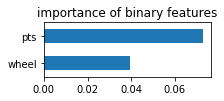

In [16]:
# importance of binary features
df_train = df[df['Train']==1]

plt.figure(figsize=(3,1))
imp_bin = pd.Series(mutual_info_classif(df_train[bin_cols],
                                     df_train['price'],
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('importance of binary features')
plt.show()

## 3. Machine learning

### 3.1. Prepare data to ML

In [17]:
train_data = df[df['Train'] == 1].drop(['Train'], axis=1)
test_data = df[df['Train'] == 0].drop(['Train'], axis=1)
X_sub = test_data.drop(['price'], axis=1).values

X = train_data.drop(['price'], axis=1).values
y = train_data.price.values

In [18]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=RANDOM_SEED)

#print('test data\t', test_data.shape)
print('ttrain data', train_data.shape)
print("X", X.shape) 
print('y ', y.shape)
print('  X_train', X_train.shape) 
print('  X_test', X_test.shape)

ttrain data (26034, 18)
X (26034, 17)
y  (26034,)
  X_train (25773, 17)
  X_test (261, 17)


### 3.2. models

###### function block

In [29]:
def get_mape(y_true, y_pred):
    """ get metric 'mape' """
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# since lesser the error, the better:
my_scorer = make_scorer(get_mape, greater_is_better=False)

def fit_model(model, param_grid):    
    """ find best parameters for model """
    cv = KFold(n_splits=3) # Define a custom kfold
    gs_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=my_scorer, cv=cv, n_jobs=-1)
    gs_model.fit(X_train, np.log(y_train + 1))
    y_pred = np.exp(gs_model.best_estimator_.predict(X_test))
    print('best params: ', gs_model.best_params_)
    print('MAPE:', get_mape(y_test, y_pred))

##### Random Forest

In [50]:
# RandomForest with default parameters
model_rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose=0)
model_rf.fit(X_train, np.log(y_train + 1))
y_pred = np.exp(model_rf.predict(X_test))
print("MAPE:", get_mape(y_test, y_pred))

MAPE: 12.961455136080263


In [51]:
mode_RF = RandomForestRegressor(random_state=RANDOM_SEED)
#print('Parameters currently in use:')
#pprint(model.get_params())

param_grid= {                         
    'n_estimators': [200, 1000],
    'min_samples_leaf': [1,2]
}
fit_model(mode_RF, param_grid)

best params:  {'min_samples_leaf': 1, 'n_estimators': 1000}
MAPE: 12.73919591491634


##### CatBoostRegressor

In [99]:
# CatBoostRegressor
model_cb = CatBoostRegressor(iterations = 50000, random_seed = RANDOM_SEED)
model_cb.fit(X_train, np.log(y_train+1), verbose=False)
y_pred = np.exp(model_cb.predict(X_test))
print("MAPE:", get_mape(y_test, y_pred))

MAPE: 11.153640484208726


##### XGBoost

In [84]:
# XGBoost with default parameters
model_xgb = XGBRegressor(alpha=1, n_estimators=1000)
model_xgb.fit(X_train, np.log(y_train+1))
y_pred = np.exp(model_xgb.predict(X_test))
print("MAPE:", get_mape(y_test, y_pred))

MAPE: 13.31344442933882


In [53]:
# XGBoost
model_XGB = XGBRegressor(random_seed = RANDOM_SEED, verbosity=0)
#pprint(model.get_params())

param_grid= {
    'n_estimators': [200, 1000],
    'learning_rate': [None, 0.3],
    'max_depth': [None, 3],
}
fit_model(model_XGB, param_grid)

best params:  {'learning_rate': None, 'max_depth': None, 'n_estimators': 200}
MAPE: 11.876368824896362


##### LightGBM

In [95]:
model_LGB = LGBMRegressor(random_seed = RANDOM_SEED)
#pprint(model_LGB.get_params())

param_grid= {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [-1,3],
    'learning_rate': [0.1, 0.3],
}
fit_model(model_LGB, param_grid)

best params:  {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 1000}
MAPE: 11.202654119368523


## 4. Submission

Make a prediction and submission
Catbost na kaggle had better result

In [100]:
#model_best = LGBMRegressor(random_seed=RANDOM_SEED, learning_rate=0.1, max_depth=-1, n_estimators=1000)
#model_best.fit(X_train, np.log(y_train+1))

In [101]:
# fit and predct
y_pred = np.exp(model_cb.predict(X_sub))

predict_submission = y_pred
submit.loc[:, 'price'] = predict_submission
submit.to_csv('data/submission.csv', index=False)
submit.head()

,sell_id,price
0,1100575026,639099.741414
1,1100549428,943155.593585
2,1100658222,865912.803621
3,1100937408,656689.233568
4,1101037972,588734.595648
